- 출처 : https://www.kaggle.com/hoshi7/goodreads-analysis-and-recommending-books 참고하여 분석

In [ ]:
!pip install isbnlib
!pip install newspaper3k
!pip install goodreads_api_client
!pip install progressbar

In [ ]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import isbnlib
from newspaper import Article
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
from progressbar import ProgressBar
import re
from scipy.cluster.vq import kmeans, vq
from pylab import plot, show
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
#import goodreads_api_client as gr
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [15]:
import warnings
warnings.filterwarnings("ignore")

## 도서관 데이터 불러오기 및 데이터 전처리

In [2]:
df= pd.read_csv('./data/final/best_book.csv',encoding='utf-8')

In [3]:
df.head(3)

,no,ranking,bookname,authors,publisher,publication_year,isbn13,addition_symbol,vol,class_no,loan_count,bookImageURL,text_reviews_count,average_rating,num_pages
0,1,1,여행의 이유 :김영하 산문,지은이: 김영하,문학동네,2019.0,9.790000e+12,3810.0,NaN,816.7,13336,https://image.aladin.co.kr/product/18827/60/co...,1540.0,9.3,216쪽
1,2,2,아몬드 (양장 특별 한정판),손원평 (지은이),창비,2017.0,9.790000e+12,3810.0,NaN,813.7,13117,http://image.aladin.co.kr/product/16839/4/cove...,997.0,9.3,263쪽
2,3,3,나미야 잡화점의 기적 :히가시노 게이고 장편소설,지은이: 히가시노 게이고 ;옮긴이: 양윤옥,현대문학,2012.0,9.790000e+12,3830.0,NaN,833.6,13004,http://image.aladin.co.kr/product/15848/6/cove...,1819.0,9.3,456쪽


In [4]:
df.columns

Index(['no', 'ranking', 'bookname', 'authors', 'publisher', 'publication_year',
       'isbn13', 'addition_symbol', 'vol', 'class_no', 'loan_count',
       'bookImageURL', 'text_reviews_count', 'average_rating', 'num_pages'],
      dtype='object')

In [5]:
# average_co 결측치 제거
df=df[pd.notnull(df['average_rating'])]

In [6]:
# 책이름 결측치 제거
df=df[pd.notnull(df['bookname'])]

In [7]:
# 책이미지 결측치 제거
df=df[pd.notnull(df['bookImageURL'])]

In [ ]:
# 작가이름 결측치 제거 
df=df[pd.notnull(df['bookImageURL'])]

- publication_year을 숫자에서 문자형으로 타입변환

In [13]:
df=df.astype({'publication_year':'str'})

In [14]:
for i in range(len(df)):
    df['publication_year'][i]=df['publication_year'][i][0:4]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
# 제목 양쪽 공백제거
for i in range(len(df)):
    df['bookname'][i]=df['bookname'][i].strip()

- 데이터프레임 인덱스 정리 필요

In [10]:
df.reset_index(drop=True,inplace=True)

In [11]:
df.head(1)

,no,ranking,bookname,authors,publisher,publication_year,isbn13,addition_symbol,vol,class_no,loan_count,bookImageURL,text_reviews_count,average_rating,num_pages
0,1,1,여행의 이유 :김영하 산문,지은이: 김영하,문학동네,2019.0,9.790000e+12,3810.0,NaN,816.7,13336,https://image.aladin.co.kr/product/18827/60/co...,1540.0,9.3,216쪽


In [16]:
df['publication_year']

0       2019
1       2017
2       2012
3       2019
4        nan
        ... 
4693     nan
4694    2018
4695     nan
4696    2019
4697    2019
Name: publication_year, Length: 4698, dtype: object

# Recommendation Engine

In [ ]:

#클러스터링을 살펴보면 Average Rating과 Ratings Count 사이의 관계에서 발생할 수있는 몇 가지 권장 사항이있을 수 있음을 추론 할 수 있습니다.

#Ratings_Distribution (자체 생성 분류 추세)을 사용하는 추천 시스템은 K Nearest Neighbors의 알고리즘과 함께 작동합니다.

#사용자가 입력 한 책을 기반으로 가장 가까운 이웃이 사용자가 좋아할만한 책으로 분류됩니다.

K#NN은 분류 및 회귀 문제 모두에 사용됩니다. 

#인스턴스의 레이블을 예측하는 분류 문제에서 먼저 거리 메트릭을 기반으로 주어진 인스턴스에 가장 가까운 k 개의 인스턴스를 찾고 
# 다수결 투표 방식 또는 가중 다수 투표 (가까운 이웃이 더 높은 가중치가 부여됨)를 기반으로 레이블을 예측합니다.

- 등급 분포를 기반으로 책을 다음과 같은 등급 척도로 분류하는 책 기능 테이블 만들기

In [28]:
df['average_rating'].describe()

count    4698.000000
mean        9.497573
std         0.798195
min         0.000000
25%         9.300000
50%         9.600000
75%         9.900000
max        10.000000
Name: average_rating, dtype: float64

In [29]:
def segregation(data):
    values = []
    for val in data.average_rating:
        if val==0:
            values.append("average_rating 0")
        elif val>0 and val<=9.3:
            values.append("average_rating q1")
        elif val>9.3 and val<=9.6:
            values.append("average_rating mean")
        elif val>9.6 and val<=9.9:
            values.append("average_rating q3")
        elif val>9.9:
            values.append("average_rating q3_max")
        else:
            values.append("NaN")
    print(len(values))
    return values

In [30]:
df.average_rating.isnull().value_counts()

False    4698
Name: average_rating, dtype: int64

<AxesSubplot:xlabel='average_rating', ylabel='Density'>

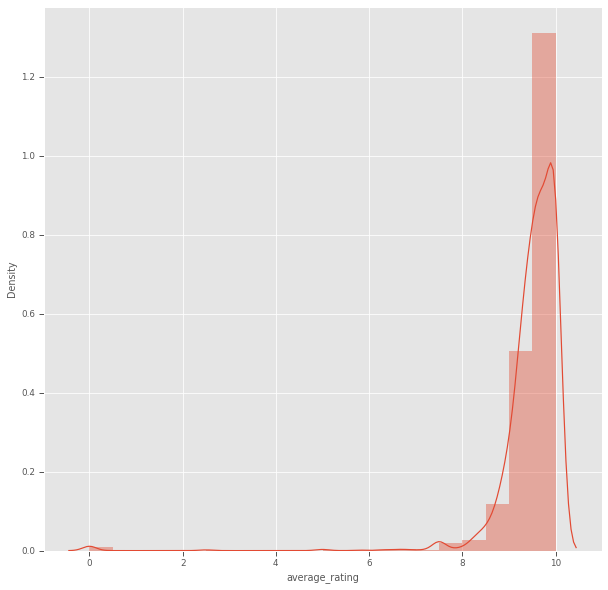

In [31]:
plt.figure(figsize=(10,10))
rating= df.average_rating.astype(float)
sns.distplot(rating, bins=20)

4698


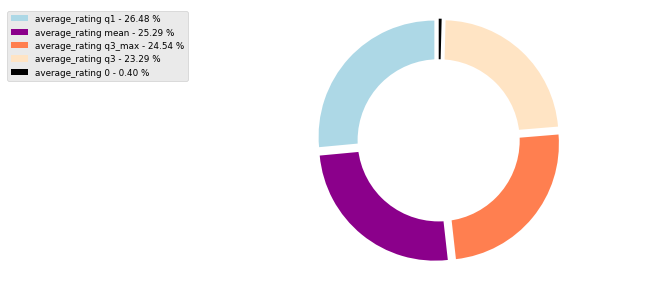

In [32]:
df['Ratings_Dist'] = segregation(df)
ratings_pie = df['Ratings_Dist'].value_counts().reset_index()
labels = ratings_pie['index']
colors = ['lightblue','darkmagenta','coral','bisque', 'black']
percent = 100.*ratings_pie['Ratings_Dist']/ratings_pie['Ratings_Dist'].sum()
fig, ax1 = plt.subplots()
ax1.pie(ratings_pie['Ratings_Dist'],colors = colors, 
        pctdistance=0.85, startangle=90, explode=(0.05, 0.05, 0.05, 0.05, 0.05))
#Draw a circle now:
centre_circle = plt.Circle((0,0), 0.70, fc ='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
#Equal Aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.tight_layout()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
plt.legend( labels, loc = 'best',bbox_to_anchor=(-0.1, 1.),)

In [ ]:
# 0 평점이 적은 것을 보아 현재 데이터에서 인지도가 낮은 책은 없는것으로 보입니다.

# q1의 비중이 가장 높은것을 보아 이 책들은 사람들의 반은 좋아하고 
# 반은 좋아하지 않는 것으로 보입니다.

# 전체적으로 사람들이 평점을 높게 주는것을 확인 할 수 있었습니다.

## 평점과 리뷰수 사이의 관계를 살펴보기

<Figure size 1080x720 with 0 Axes>

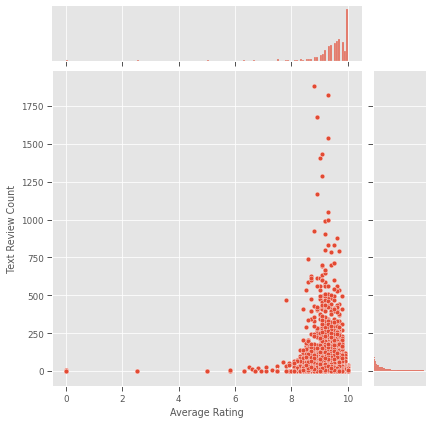

In [56]:
#Checking for any relation between them.
plt.figure(figsize=(15,10))
sns.set_context('paper')
ax =sns.jointplot(x="average_rating",y='text_reviews_count', kind='scatter',  data= df[['text_reviews_count', 'average_rating']])
ax.set_axis_labels("Average Rating", "Text Review Count")
plt.show()

In [ ]:
# 책에 대한 평점이 대부분 9점이라는 것을 파악 할 수 있다
# 리뷰수는 500개 이하가 대부분인것을 확인 할 수 있다

## TOPIC MODELING _ kmeans

In [22]:
trial = df[['average_rating','loan_count','text_reviews_count']]
data = np.asarray([np.asarray(trial['average_rating']), np.asarray(trial['loan_count']),np.asarray(trial['text_reviews_count'])]).T

Text(0.5, 1.0, 'Elbow Curve')

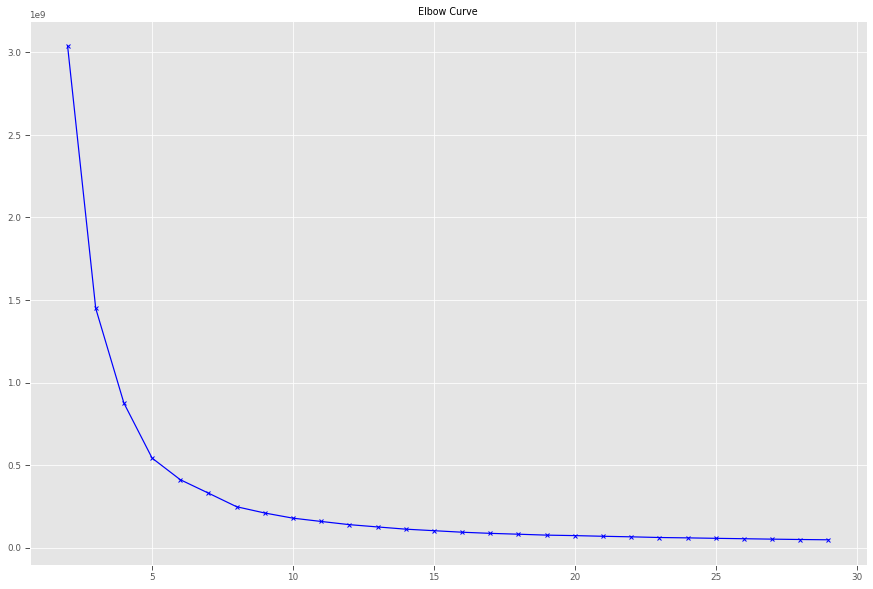

In [23]:
X = data
distortions = []
for k in range(2,30):
    k_means = KMeans(n_clusters = k)
    k_means.fit(X)
    distortions.append(k_means.inertia_)

fig = plt.figure(figsize=(15,10))
plt.plot(range(2,30), distortions, 'bx-')
plt.title("Elbow Curve")

# elbow point가 5에서 많이 꺾이는 것을 확인할 수 있다.

In [24]:
#elbow point를 통해 군집의 수를 5로 정함
centroids, _ = kmeans(data, 5)

#각 샘플을 클러스터에 할당하기 
#벡터 양자화 : N개의 특징 벡터 집합 X를 k개의 특징 벡터들의 집합 Y로 매핑하는것

idx, _ = vq(data, centroids)

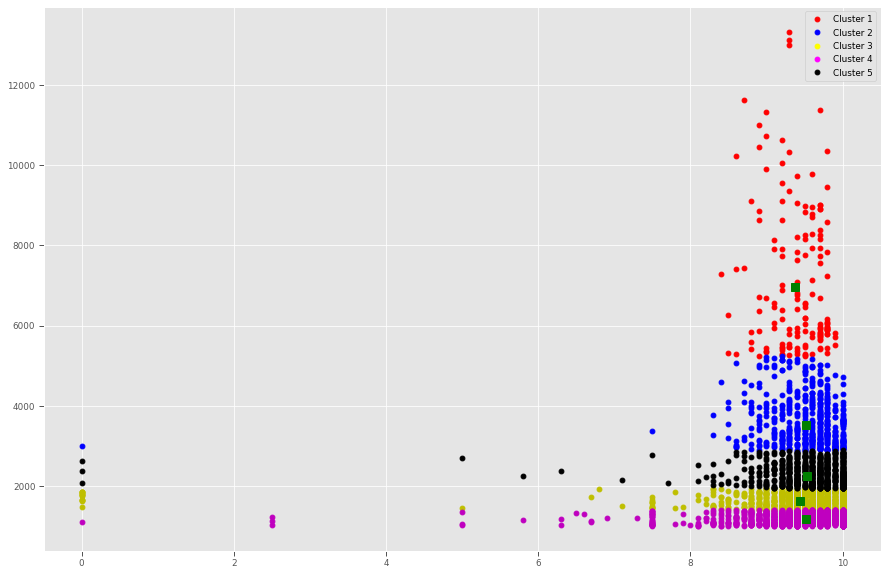

In [25]:
# some plotting using numpy's logical indexing
sns.set_context('paper')
plt.figure(figsize=(15,10))
plt.plot(data[idx==0,0],data[idx==0,1],'or',#red circles
     data[idx==1,0],data[idx==1,1],'ob',#blue circles
     data[idx==2,0],data[idx==2,1],'oy', #yellow circles
     data[idx==3,0],data[idx==3,1],'om', #magenta circles
     data[idx==4,0],data[idx==4,1],'ok',#black circles
    
     
        
        
        
        
        )
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8, )




circle1 = Line2D(range(1), range(1), color = 'red', linewidth = 0, marker= 'o', markerfacecolor='red')
circle2 = Line2D(range(1), range(1), color = 'blue', linewidth = 0,marker= 'o', markerfacecolor='blue')
circle3 = Line2D(range(1), range(1), color = 'yellow',linewidth=0,  marker= 'o', markerfacecolor='yellow')
circle4 = Line2D(range(1), range(1), color = 'magenta', linewidth=0,marker= 'o', markerfacecolor='magenta')
circle5 = Line2D(range(1), range(1), color = 'black', linewidth = 0,marker= 'o', markerfacecolor='black')

plt.legend((circle1, circle2, circle3, circle4, circle5)
           , ('Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'), numpoints = 1, loc = 0, )


plt.show()

In [33]:
books_features = pd.concat([df['Ratings_Dist'].str.get_dummies(sep=","), df['average_rating'], df['loan_count'],df['text_reviews_count']], axis=1)

In [34]:
books_features.head()

,average_rating 0,average_rating mean,average_rating q1,average_rating q3,average_rating q3_max,average_rating,loan_count,text_reviews_count
0,0,0,1,0,0,9.3,13336,1540.0
1,0,0,1,0,0,9.3,13117,997.0
2,0,0,1,0,0,9.3,13004,1819.0
3,0,0,1,0,0,8.7,11629,244.0
4,0,0,0,1,0,9.7,11385,325.0


In [35]:
len(books_features)

4698

In [ ]:

# 클러스터링을 살펴보면 Average Rating과 Ratings Count 사이의 관계에서 
# 발생할 수있는 몇 가지 권장 사항이있을 수 있음을 추론 할 수 있습니다.

# Ratings_Distribution (자체 생성 분류 추세)을 사용하면 추천 시스템은 
# K Nearest Neighbors의 알고리즘으로 작동합니다.

# 사용자가 입력 한 책을 기반으로 가장 가까운 이웃이 사용자가 좋아할만한 책으로 분류됩니다.

# KNN은 분류 및 회귀 문제 모두에 사용됩니다. 
# 인스턴스의 레이블을 예측하는 분류 문제에서 먼저 거리 메트릭을 기반으로 
# 주어진 인스턴스에 가장 가까운 k 개의 인스턴스를 찾고 다수결 투표 방식 
# 또는 가중 다수 투표 (가까운 이웃이 더 높은 가중치가 부여됨)를 기반으로 레이블을 예측합니다.

In [ ]:
#  최소-최대 스케일러는 일부 책에 엄청난 양의 기능이 있지만 
# 나머지 책은 기능이 적기 때문에 발생했을 편향을 줄이는 데 사용 
# Min-Max 스케일러는 그들 모두에 대한 중앙값을 찾아 동등 화합니다.

- k-NN 은 대표적인 분류 알고리즘 중의 하나이다.
- k-NN 에서 NN 은 Nearest Neighbors 즉, 가장 가까운 점들이라는 의미이며, k 는 가장 가까운 이웃의 갯수를 의미한다.
- 예측하려고 하는 점 주위에 가장 가까이 있는 점들의 타겟값(클래스) 를 비교하여 해당 클래스를 판정한다.

In [36]:
min_max_scaler = MinMaxScaler()
books_features = min_max_scaler.fit_transform(books_features)

In [37]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(books_features)
distance, indices = model.kneighbors(books_features)

In [38]:
# 책 이름을 찾는 데 도움이되는 특정 기능 만들기 :

# 제목에서 색인 가져 오기
# 일부 이름에서 ID 가져 오기 (모든 사람이 모든 이름을 기억할 수는 없기 때문에)
# 기능 데이터 세트에서 유사한 책을 인쇄합니다. (이는 가장 가까운 이웃의 인덱스 지표를 사용하여 책을 선택합니다.)

In [53]:
def get_index_from_name(name):
    return df[df["bookname"]==name].index.tolist()[0]

all_books_names = list(df.bookname.values)

# 특정단어를 통해 책 찾기
def get_id_from_partial_name(partial):
    for name in all_books_names:
        if partial in name:
            print(name)


# 내가 검색한 책의 인기도와 유사한 책 5권 추천
def print_similar_books(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(df.iloc[id]["bookname"],df.iloc[id]["authors"],df.iloc[id]["bookImageURL"])
    if query:
        found_id = get_index_from_name(query)
        for id in indices[found_id][1:]:
            print(df.iloc[id]["bookname"],df.iloc[id]["authors"],df.iloc[id]["bookImageURL"])

In [ ]:
# 시스템이 잘 작동하는지 확인하기

# System by name: 여행의 이유 :김영하 산문
# System by Name: (법륜 스님의) 행복 :행복해지고 싶지만 길을 몰라 헤매는 당신에게 
# System by partial name: 해리포터

In [45]:
# 평점이랑 많이 빌린책을 종합적으로 봤을때 인기있는 책 찾기 - 광고성이 없는 순수함..?
print_similar_books("여행의 이유 :김영하 산문")

나미야 잡화점의 기적 :히가시노 게이고 장편소설 지은이: 히가시노 게이고 ;옮긴이: 양윤옥 http://image.aladin.co.kr/product/15848/6/cover/k622533431_1.jpg
82년생 김지영 :조남주 장편소설 지은이: 조남주 https://bookthumb-phinf.pstatic.net/cover/112/111/11211133.jpg?type=m1&udate=20180530
나는 나로 살기로 했다 :냉담한 현실에서 어른살이를 위한 to do list 글·그림: 김수현 http://image.aladin.co.kr/product/16751/86/cover/k642534567_2.jpg
아몬드 (양장 특별 한정판) 손원평 (지은이) http://image.aladin.co.kr/product/16839/4/cover/k492534773_1.jpg
언어의 온도 :말과 글에는 나름의 따뜻함과 차가움이 있다 지은이: 이기주 http://image.aladin.co.kr/product/14842/6/cover/k742532452_1.jpg


In [46]:
print_similar_books('나미야 잡화점의 기적 :히가시노 게이고 장편소설')

여행의 이유 :김영하 산문 지은이: 김영하 https://image.aladin.co.kr/product/18827/60/cover/8954655971_2.jpg
82년생 김지영 :조남주 장편소설 지은이: 조남주 https://bookthumb-phinf.pstatic.net/cover/112/111/11211133.jpg?type=m1&udate=20180530
언어의 온도 :말과 글에는 나름의 따뜻함과 차가움이 있다 지은이: 이기주 http://image.aladin.co.kr/product/14842/6/cover/k742532452_1.jpg
나는 나로 살기로 했다 :냉담한 현실에서 어른살이를 위한 to do list 글·그림: 김수현 http://image.aladin.co.kr/product/16751/86/cover/k642534567_2.jpg
아몬드 (양장 특별 한정판) 손원평 (지은이) http://image.aladin.co.kr/product/16839/4/cover/k492534773_1.jpg


In [55]:
print_similar_books("(법륜 스님의) 행복 :행복해지고 싶지만 길을 몰라 헤매는 당신에게")

틀 밖에서 놀게 하라 :세계 창의력 교육 노벨상 '토런스상' 수상, 김경희 교수의 창의영재 교육법 김경희 지음 https://image.aladin.co.kr/product/21945/70/cover/8965709598_1.jpg
언컨택트 =더 많은 연결을 위한 새로운 시대 진화 코드 /Uncontact 김용섭 지음 https://image.aladin.co.kr/product/23775/60/cover/k012639065_1.jpg
이상한 손님 백희나 https://bookthumb-phinf.pstatic.net/cover/134/460/13446004.jpg?type=m1&udate=20180731
수학이 필요한 순간 :인간은 얼마나 깊게 생각할 수 있는가 지은이: 김민형 https://image.aladin.co.kr/product/15892/11/cover/s802533642_1.jpg
분신 히가시노 게이고 (지은이), 김난주 (옮긴이) https://image.aladin.co.kr/product/22056/44/cover/8990982839_1.jpg


In [54]:
get_id_from_partial_name("해리포터")

해리포터와 마법사의 돌
해리포터와 마법사의 돌
해리포터 :마법사의 돌
해리포터와 비밀의 방
해리포터와 비밀의 방
해리포터 :마법사의 돌
해리포터 :비밀의 방
해리포터 :스페셜 리허설 에디션 대본
해리포터 :비밀의 방
해리포터와 불의 잔
해리포터 :스페셜 리허설 에디션 대본
해리포터와 아즈카반의 죄수
해리포터와 아즈카반의 죄수
해리포터 :아즈카반의 죄수
해리포터와 불의 잔
해리포터와 불사조 기사단
해리포터 :아즈카반의 죄수
해리포터 :불의 잔
해리포터와 불의 잔
해리포터와 불사조 기사단
해리포터와 혼혈왕자
해리포터 :불의 잔
해리포터와 불사조 기사단
해리포터와 불사조 기사단
해리포터와 불사조 기사단
해리포터 :불사조 기사단
해리포터와 죽음의 성물
해리포터와 혼혈왕자
해리포터 :불의 잔
해리포터와 죽음의 성물
해리포터 :혼혈 왕자
해리포터와 혼혈왕자
해리포터 :불의 잔
해리포터 :불사조 기사단
해리포터 :죽음의 성물
해리포터 :불사조 기사단
해리포터 :혼혈 왕자
해리포터 :죽음의 성물
해리포터 :불사조 기사단
해리포터 :불사조 기사단
해리포터 :혼혈 왕자
해리포터 :죽음의 성물
해리포터 :혼혈 왕자
